![](assets/preprocessing_targets.png)

In [18]:
from fastai.data.all import *
from librosa.feature import melspectrogram
from librosa import power_to_db
import librosa

In [52]:
path = Path("../data/LJSpeech-1.1/wavs")
sample_path = path/"LJ001-0001.wav"

In [53]:
waveform, _ = librosa.load(sample_path)

In [89]:
n_fft = 1024
hop_length = 256
sample_rate = 22050

### Mel Spectrogram

In [45]:
def Load_audio(sample_rate):
    @Transform
    def _inner(path):
        waveform, _ = librosa.load(path, sr=sample_rate)
        return waveform
    return _inner
        

def Mel_transform(sample_rate, n_fft, hop_length):
    @Transform
    def _inner(y): 
        return melspectrogram(y=y, sr=sample_rate, n_fft=n_fft, hop_length=hop_length)
    return _inner

db_transform = Transform(power_to_db)

In [46]:
mel_pipeline = Pipeline([Load_audio(sample_rate), 
                         Mel_transform(sample_rate, n_fft, hop_length), 
                         db_transform])

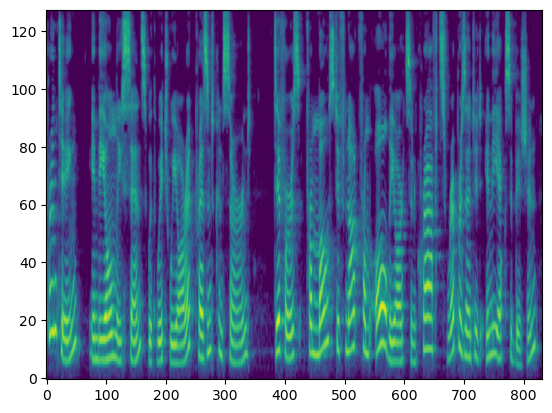

In [50]:
mels = mel_pipeline()
plt.imshow(mels, aspect='auto', origin="lower");

### Energy

In [ ]:
import numpy as np

In [190]:
def Stft_transform(n_fft, hop_length):
    @Transform
    def _inner(y): 
        return librosa.stft(y=y, n_fft=n_fft, hop_length=hop_length)
    return _inner

@Transform
def extract_amplitude(spectrogram):
    return librosa.magphase(spectrogram)[0]

@Transform
def l2_norm(inputs):
    return np.sqrt(np.sum(inputs ** 2, axis=0))

In [191]:
energy_pipeline = Pipeline([Load_audio(sample_rate), 
                            Stft_transform(n_fft, hop_length),
                            extract_amplitude,
                            l2_norm])

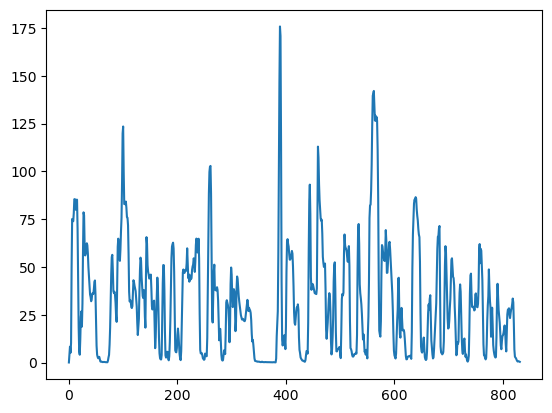

In [192]:
energy = energy_pipeline(sample_path)
plt.plot(energy);

### Pitch Contour

In [87]:
import pyworld as pw

In [99]:
f0, t_positions = pw.dio(waveform.astype(np.float64), 
                         sample_rate, 
                         frame_period=hop_length/sample_rate*1000)

In [108]:
pitch_contour = pw.stonemask(waveform.astype(np.float64), f0, t_positions, sample_rate)

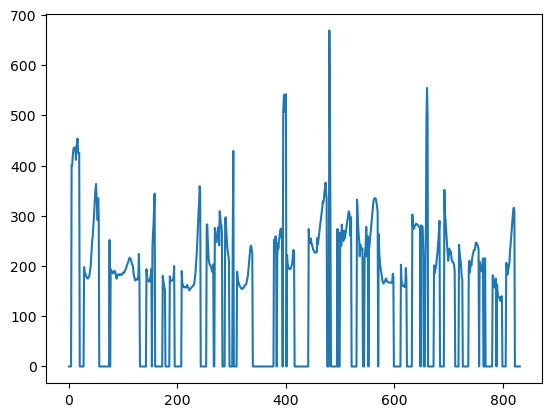

In [110]:
plt.plot(pitch_contour);

To make the CWT work better we need to do preprocessing steps on the pitch contour, which are:
1. Interpolate to fill in gaps
2. Transform to logrithmic domain
3. Normalize

### 1. Interpolate to fill in gaps

In [172]:
from scipy.interpolate import interp1d

In [173]:
nonzero_indexs = np.where(pitch_contour != 0)[0]

In [174]:
interp_fn = interp1d(nonzero_indexs, pitch_contour[nonzero_indexs], 
                     bounds_error=False, fill_value="extrapolate")

In [175]:
out = interp_fn(np.arange(0, len(pitch_contour)))

### 2. Transform to logrithmic domain

In [176]:
out = np.log(out)

### 3. Normalize

In [177]:
from sklearn.preprocessing import normalize

In [178]:
normalized_pitch_controur = normalize(out.reshape(1,-1)).reshape(-1)

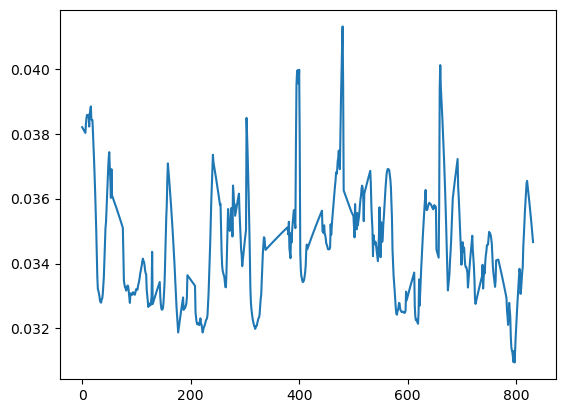

In [179]:
plt.plot(normalize_pitch_controur);

In [197]:
def Extract_pitch_contour(sample_rate, hop_length):
    @Transform
    def _inner(waveform):
        f0, t_positions = pw.dio(waveform.astype(np.float64), 
                         sample_rate, 
                         frame_period=hop_length/sample_rate*1000)
        pitch_contour = pw.stonemask(waveform.astype(np.float64), 
                                     f0, t_positions, sample_rate)
        return pitch_contour
    return _inner

@Transform
def interploate(pitch_contour):
    nonzero_indexs = np.where(pitch_contour != 0)[0]
    interp_fn = interp1d(nonzero_indexs, pitch_contour[nonzero_indexs], 
                     bounds_error=False, fill_value="extrapolate")
    return interp_fn(np.arange(0, len(pitch_contour)))

log_transform = Transform(np.log)

@Transform
def normalize_transform(inputs):
    return normalize(out.reshape(1,-1)).reshape(-1)

In [218]:
pitch_pipeline = Pipeline([Extract_pitch_contour(sample_rate, hop_length)])

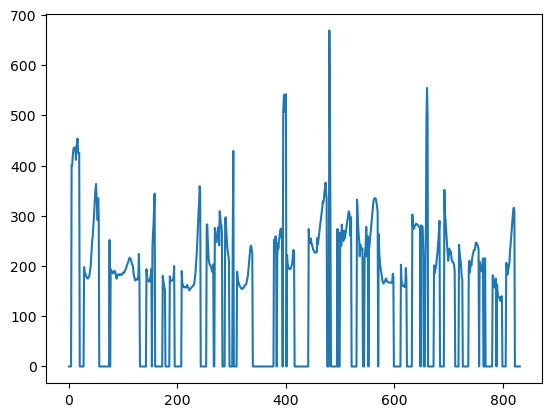

In [219]:
plt.plot(pitch_pipeline(waveform));

### Duration

In [241]:
import tgt

In [283]:
@Transform
def load_text_grid(wav_path):
    tg_path = wav_path.parent/(wav_path.name.split(".")[0] + ".TextGrid")
    text_grid = tgt.io.read_textgrid(tg_path)
    return text_grid.get_tier_by_name("phones")

def Get_durations(sample_rate, hop_length):
    def _inner(text_grid):
        phones, durations = [], []
        for interval in text_grid:
            start, end, phoneme = interval.start_time, interval.end_time, interval.text

            duration = int(np.round(end*sample_rate/hop_length) -
                           np.round(start*sample_rate/hop_length))

            phones.append(phoneme)
            durations.append(duration)
        return phones, durations
    return _inner

In [284]:
duration_pipeline = Pipeline([load_text_grid, Get_durations(sample_rate, hop_length)])

In [292]:
phones, durations = duration_pipeline(sample_path)
list(zip(phones, durations))[:5]

[('P', 3), ('R', 3), ('IH1', 10), ('N', 2), ('T', 7)]